![texto alternativo](https://drive.google.com/uc?id=1CXVh-Dy6T792nWexE0kH45AOqqFj2_wG)


<center> <h1>Maestría en Analytics</h1> </center>
<center> <h1>Modelos Avanzados para el Análisis de Datos 1</h1> </center>
<center> <h1>Exercise 8 - Car Price Prediction </h1> </center>

**Grupo 3**
- Carlos Francisco Silva Ortiz
- Sergio Alberto Mora Pardo 
- Nidia Marcela Ortiz Sandoval
- Germán Guillermo Torres

29 June 2020

# Exercise 8

## Car Price Prediction

Predict if the price of a car is low or high

In [592]:
#Leyendo datos, convirtiendo dummies
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data

,Price,Year,Mileage,Model,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
15,17991,2016,29242,CamryLE,0,0,0,0,1,0,0
47,15895,2015,26465,CamryLE,0,0,0,0,1,0,0
85,15099,2012,46739,Camry4dr,0,1,0,0,0,0,0
141,16667,2017,41722,CamrySE,0,0,0,0,0,1,0
226,12855,2014,77669,CamryXLE,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
499785,16988,2014,46488,CamryL,0,0,0,1,0,0,0
499889,17798,2016,10232,CamrySE,0,0,0,0,0,1,0
499937,17360,2016,34672,CamryLE,0,0,0,0,1,0,0
499971,16988,2014,42032,CamryL,0,0,0,1,0,0,0


In [593]:
#Definiendo niveles para variables de respuesta Y. Es 1 cuando supera la media de los valores.
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [301]:
data.shape

(13150, 10)

In [594]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [438]:
y.mean()

0.5795437262357415

En general, entramos las categorias de la variable de respuesta balanceadas.

In [595]:
# Partir para base de entrenamiento y test en X y y.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [596]:
#Definiendo función para índice de Gini
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [597]:
#Definiendo función para Impurity
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [598]:
# Definiendo función para particiones por percentiles vs predictores.
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [599]:
# Definiendo función para crecer manualmente árbol de clasificación.
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [600]:
#Definir función para predicción
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [445]:
tree8_1 = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [446]:
tree8_1

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': [1, 33000.0],
      'n_samples': 23,
      'gain': 0.03456656764785304,
      'sl': {'y_pred': 0,
       'y_prob': 0.05555555555555555,
       'level': 6,
       'split': -1,
       'n_sam

In [447]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [448]:
res = tree_predict(X_test, tree8_1)
Accuracy8_1 = accuracy_score(y_test, res)
Accuracy8_1

0.8433179723502304

Realizar el Árbol de Clasificación manualmente, nos arroja una exactitud de 84.33% al probarlo con y_test a un split del 0.33

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

In [565]:
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [557]:
#Entrenar arboles
trees = {}
for i in range(n_estimators):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=None, num_pct=10)


In [558]:
#Dataframe para el predict
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))


In [561]:
# Predict 
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred_df

,0,1,2,3,4,5,6,7,8,9
332784,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
244795,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
366403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269482,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5010,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [562]:
# Predict using majority voting
y_pred_df.sum(axis=1)[:10]

332784     5.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
330419     0.0
205915    10.0
2836       9.0
250833    10.0
126784     0.0
dtype: float64

In [568]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.8626728110599078

Para este Bagging con 10 árboles creados manualmente, obtenemos un Accuracy de 86.26%, siendo más alto que el obtenido para el arbol individual.

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [601]:
def tree_grow_mf(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=len(X.columns)):
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    if max_features>len(X.columns):
        max_features=len(X.columns)
        print("El maximo de columnas soportable es %f", len(X.columns))
    
    import random

    j, split, gain = best_split(X.iloc[:, random.sample(range(0, len(X.columns)), max_features)], y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [607]:
tree8_3 = tree_grow_mf(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=5)

In [608]:
res8_3 = tree_predict(X_test, tree8_3)
accuracy8_3 = accuracy_score(y_test, res8_3)
accuracy8_3

0.8433179723502304

Cuando se incorpora al modelo de clasificación manual, la variable max_features (usando en este caso 9), obtenemos Accuracy del 84.33%

In [614]:
tree8_3_2 = tree_grow_mf(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=2)
res8_3_2 = tree_predict(X_test, tree8_3_2)
accuracy8_3_2 = accuracy_score(y_test, res8_3_2)
accuracy8_3_2

0.5824884792626728

In [618]:
tree8_3_4 = tree_grow_mf(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=4)
res8_3_4 = tree_predict(X_test, tree8_3_4)
accuracy8_3_4 = accuracy_score(y_test, res8_3_4)
accuracy8_3_4

0.8433179723502304

In [628]:
tree8_3_3 = tree_grow_mf(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=3)
res8_3_3 = tree_predict(X_test, tree8_3_3)
accuracy8_3_3 = accuracy_score(y_test, res8_3_3)
accuracy8_3_3

0.8442396313364056

Al Probar los cambios en el parámetro max_features obtenemos los siguientes resultados:
* max_features=5, Acurracy = 84.33%
* max_features=2, Acurracy = 58.24%
* max_features=4, Acurracy = 84.33%
* max_features=3, Acurracy = 84.23%

# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [516]:
###Enfoque Manual para max_features = log(n_features)

def tree_grow_mf2(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    max_features = np.int(np.round(np.log(len(X.columns)), decimals=0))
    
    import random

    j, split, gain = best_split(X.iloc[:, random.sample(range(0, len(X.columns)), max_features)], y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [518]:
tree8_4 = tree_grow_mf2(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)
res8_4 = tree_predict(X_test, tree8_4)
accuracy8_4 = accuracy_score(y_test, res8_4)
accuracy8_4

0.8447004608294931

Al hacer el Bagging de estos 10 arboles, usando el criterio Log y de forma manual, encontramos un Accuracy del 84.47%

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [150]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=200)
clf

RandomForestClassifier(n_estimators=200)

In [151]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [152]:
#check the accuracy using actual and predicted values.
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.838479262672811


In [153]:
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.836198
std       0.011661
min       0.819772
25%       0.833460
50%       0.833460
75%       0.840494
max       0.859316
dtype: float64

**Random Forest**: Con este modelo, los resultados del Accuracy son 83,84%  cuando tomamos el split de las bases (33% para Test). Al hacerlo también con Crossvalidation Kfolds=10, la media del Accuracy obtenida es de 83.61%.

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [175]:
feature_cols = X.columns
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

**Tuning n_estimators**

In [182]:
# Tuning con Crossvalidation
# list of values to try for n_estimators
estimator_range = range(1, 200, 2)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

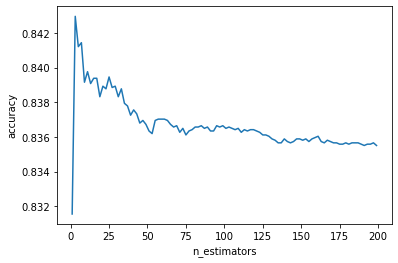

In [183]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy');

In [184]:
# show the best accuracy and the corresponding n_estimador
sorted(zip(accuracy_scores, estimator_range))[::-1][0]

(0.8429657794676807, 3)

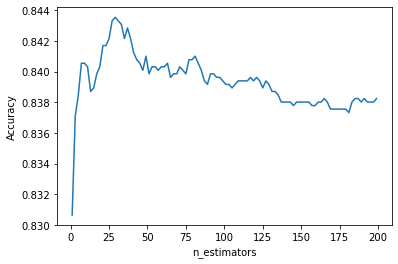

In [185]:
# Tuning con el split de test al 0.33
# list of values to try for n_estimators
estimator_range = range(1, 200, 2)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    clf.fit(X_train,y_train)
    accuracy_scores.append(accuracy_score(y_test,clf.predict(X_test)))
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy');

In [186]:
# show the best accuracy and the corresponding n_estimador
sorted(zip(accuracy_scores, estimator_range))[::-1][0]

(0.8435483870967742, 29)

**n_estimators:** Con CV el mejor parámetro se encuentra en 84.29% con 3 árboles. Por otra parte, usando el split inicial de test al 0.33, el mejor desempeño respecto a la exactitud, lo conseguimos en 84.35% con 29 árboles.

**Tuning max_features**

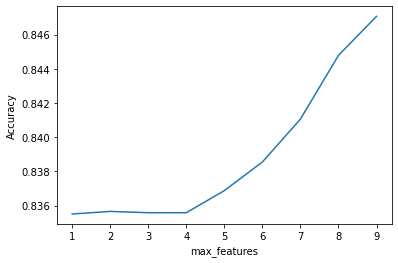

In [187]:
#Tuning max_features con CV
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy');


In [188]:
# show the best accuracy and the corresponding max_features
sorted(zip(accuracy_scores, feature_range))[::-1][0]

(0.8470722433460075, 9)

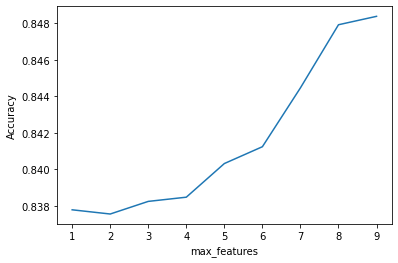

In [191]:
#Tuning max_features con split inicial 0.33
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    clf.fit(X_train,y_train)
    accuracy_scores.append(accuracy_score(y_test,clf.predict(X_test)).mean())

plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy');

In [192]:
# show the best accuracy and the corresponding max_features
sorted(zip(accuracy_scores, feature_range))[::-1][0]


(0.8483870967741935, 9)

**max_features**: al emplear ambos enfoques, el número de predictores coindice en que debería ser 9. Las exactitudes obtenidas son muy similares. Con CV = 84.7%, con el split de test al 0.33 = 84.83%

**Tuning max_depth**

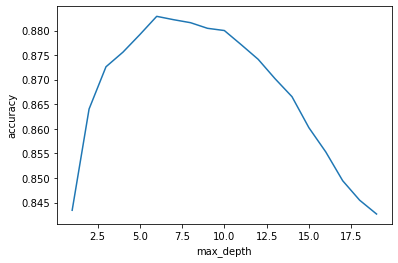

In [195]:
# Tuning con Crossvalidation
# list of values to try for n_estimators
max_depth_range = range(1, 20, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for max_d in max_depth_range:
    clf = RandomForestClassifier(n_estimators=200, max_depth=max_d, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy');

In [197]:
# show the best accuracy and the corresponding max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8828897338403042, 6)

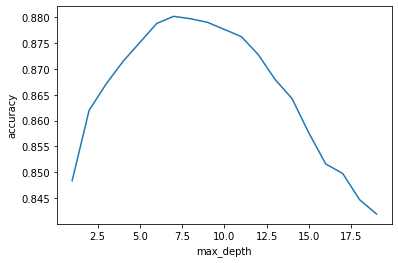

In [198]:
# Tunning con el split de test al 0.33
# list of values to try for max_depth
max_depth_range = range(1, 20, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for max_d in max_depth_range:
    clf = RandomForestClassifier(n_estimators=200, max_depth=max_d, random_state=1, n_jobs=-1)
    clf.fit(X_train,y_train)
    accuracy_scores.append(accuracy_score(y_test,clf.predict(X_test)))
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy');

In [199]:
# show the best accuracy and the corresponding max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.880184331797235, 7)

**Max_Depth**: La profundidad máxima encontrada para el modelo es de 6 layers (Accuracy de 88.28% con CV) o de 7 layers (Accuracy del 88.01% para el modelo entrenado y probado con split al 0.33)

**Construyendo Modelo con los mejores parámetros**

In [210]:
#Fitting a Random Forest with the best parameters      

clf = RandomForestClassifier(n_estimators=29, max_features=9, max_depth=6, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(max_depth=6, max_features=9, n_estimators=29, n_jobs=-1,
                       random_state=1)

In [211]:
pd.Series(cross_val_score(clf, X, y, cv=3)).describe()

count    3.000000
mean     0.884183
std      0.002327
min      0.881615
25%      0.883199
50%      0.884782
75%      0.885467
max      0.886151
dtype: float64

**Usando la combinación de los mejores parámetros encontramos una media de 88.4% en Accuracy, el mejor conseguido hasta este punto con RandomForest**

In [212]:
# Determinando la importancia de las variables
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000006
7,M_CamrySE,0.000385
3,M_Camry4dr,0.000409
5,M_CamryL,0.001722
2,M_Camry,0.008006
8,M_CamryXLE,0.008488
6,M_CamryLE,0.018919
0,Year,0.331837
1,Mileage,0.630227


La variable que más aporta al modelo es "Mileage"

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [214]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score

In [216]:
clf = XGBClassifier()
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [217]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test.values), accuracy_score(y_pred, y_test.values)

(0.8989412897016361, 0.8790322580645161)

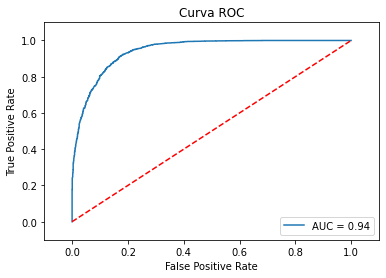

In [226]:
import matplotlib.pyplot as plt
from sklearn import metrics
y_preds = clf.predict_proba(X_test)

preds = y_preds[:,1]

(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

plt.clf()

plt.title('Curva ROC')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))


plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

**XGBoost**: para este modelo se obtiene un muy buen resultado de Accuracy 87.90%. El F1_Score también indica un modelo de muy buen desempeño: 89.89%. Obtenemos el resultado de la métrica AUC en 0.94

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

In [121]:
np.arange(0,100,10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

### Xtreme Gradient Boosting


In [235]:

accuracy = list()
param = list()

for lr in np.arange(0.75,0.8,0.005):
    for gamm in np.arange(55,65,1):
        for col_s in np.arange(0.8,1,0.02):
            clf = XGBClassifier(learning_rate=lr, gamma=gamm, colsample_bytree=col_s)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            param.append([lr, gamm, col_s])
            accuracy.append(accuracy_score(y_pred, y_test.values))
sorted(zip(accuracy, param))[::-1][0]


(0.8841013824884792, [0.75, 60, 0.9800000000000002])

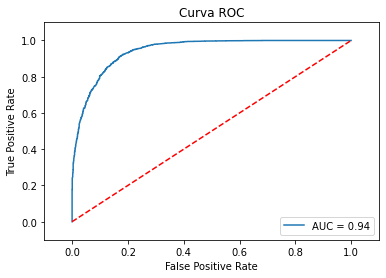

In [236]:
import matplotlib.pyplot as plt
from sklearn import metrics
y_preds = clf.predict_proba(X_test)

preds = y_preds[:,1]

(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

plt.clf()

plt.title('Curva ROC')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))


plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

### Xtreme Gradient Boosting


Al modificar los parámetros de Xtreme Gradient Boosting encontramos uno de los mejores Accuracies conseguidos en todo el taller, es decir 88.41% (igual a RandomForest cuando combina los mejores parámetros). Los parámetros modificados, conseguidos y explicados, se muestran a continuación:

* Learning_rate=0.75, corresponde a la tasa de aprendizaje del modelo y valor que permite al modelo ser más robusto al reducir los pesos en cada iteración.
* Gamma=60, corresponde a la reducción de pérdida mínima requerida para hacer una partición adicional en un nodo del árbol. actua como un parámetro de regularización.
* Colsample_bytree=0.98, corresponde a la proporción de submuestra de columnas al construir cada árbol. 

